# FIT 5202 - Data processing for Big Data

# Assignment - 02

# Part A- Creating  Spark Session  and Loading the Data

## Step 1: Import pyspark and initialize Spark

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()

if (sc is None):
    sc = SparkContext(master="local[4]", appName="Assignment 2: Rain in Australia: Predict rain tomorrow in Australia")
spark = SparkSession(sparkContext=sc)

## Step 2: Load the dataset and print the schema and total number of entries

### Load Dataset and print schema:

In [2]:
df = spark.read.csv("weatherAUS.csv", sep = ",", inferSchema=True, header=True)
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



### Total Number of Entries in the dataset:

In [3]:
print("Total Number of entries in the dataset: {0} entries".format(df.count()))

Total Number of entries in the dataset: 142193 entries


# Part B- Data Cleaning and Processing

## Step 3: Delete columns for dataset

In [4]:
df = df.drop("Date", "Location", "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm")

## Step 4: Print the number of missing data in each column.

In [5]:
print("Number of null values in each columns: ")
def countNull(forNullCountDf):
    i = 0
    for x in forNullCountDf.columns:
        print("\t",forNullCountDf.columns[i], ' :', forNullCountDf.filter(forNullCountDf[forNullCountDf.columns[i]] == 'NA').count())
        i += 1
countNull(df)

Number of null values in each columns: 
	 MinTemp  : 637
	 MaxTemp  : 322
	 Rainfall  : 1406
	 WindGustDir  : 9330
	 WindGustSpeed  : 9270
	 WindDir9am  : 10013
	 WindDir3pm  : 3778
	 WindSpeed9am  : 1348
	 WindSpeed3pm  : 2630
	 Humidity9am  : 1774
	 Humidity3pm  : 3610
	 Pressure9am  : 14014
	 Pressure3pm  : 13981
	 RainToday  : 1406
	 RainTomorrow  : 0


## Step 5: Fill the missing data with average value and maximum occurrence value

In [6]:
from pyspark.sql.functions import when
newestDf = df

avgDf = df.agg({x : "avg" for x in df.columns})
rAvgDf = avgDf.drop("avg(RainTomorrow)", "avg(RainToday)", "avg(WindDir9am)", "avg(WindDir3pm)", "avg(WindGustDir)")
avgValues = rAvgDf.collect()[0]

# helps to return the average of a column using rAvgDf dataframe.
def findAvg(colName):
    column = "avg(" + colName + ")"
    return avgValues[column]

# helps to change the "NA" values to average of corresponding columns.
def changeNulls(colName, toChangeDf):
    updatedDf = toChangeDf.withColumn(colName, when(toChangeDf[colName] == 'NA', findAvg(colName)).otherwise(toChangeDf[colName]))
    return updatedDf


# just a proff check method to check weather the NA values are changed with the average of that column or not.
# def x(colNamee, toViewDf):
#     i = 0
#     for x in toViewDf.columns:
#         print(toViewDf.columns[i], ' :', toViewDf.filter(toViewDf[toViewDf.columns[i]] == findAvg(colNamee)).count())
#         i += 1


# a method that is substitute of changeNulls method, helps to run more effeciently
def changeNullwithAvg(colName, dFrame):
    updatedDataFrame = changeNulls(colName, dFrame)
    return updatedDataFrame




In [7]:
numaricColums = ["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm" , "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"]

# A for loop to apply changeNullwithAvg to all numaric columns of dataframe
for i in numaricColums:
    newestDf = changeNullwithAvg(i, newestDf)

In [8]:
from pyspark.sql.functions import desc

# A method to find out the most frequent item of a column
def maxOcc(s):
    return df.groupBy(s).count().sort(desc("count")).collect()[0][0]

In [9]:
# helps to change NA values to maximum value of that column.
def changeNullsString(colName, toChangeDf):
    updatedDf = toChangeDf.withColumn(colName, when(toChangeDf[colName] == 'NA', maxOcc(colName)).otherwise(toChangeDf[colName]))
    return updatedDf

In [10]:
nonNumaricColumns = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]

# for loop to run changeNullsString method for every non numaric columns of dataframe.
for j in nonNumaricColumns:
    newestDf = changeNullsString(j, newestDf)

In [11]:
# to print cleaned dataframe
# newestDf.show()

## Step 6: Data transformation

### Conducting type casting for numeric columns.

In [12]:
from pyspark.sql.types import DoubleType

for i in numaricColums:
    updatedDataframe = newestDf.withColumn(i, newestDf[i].cast(DoubleType()))
    newestDf = updatedDataframe

### Using string indexer to convert non-numerical values into numbers.

In [13]:
from pyspark.ml.feature import StringIndexer

for i in nonNumaricColumns:
    l_indexer = StringIndexer(inputCol=i, outputCol= i + 'Index')
    transformedDf = l_indexer.fit(newestDf).transform(newestDf)
    newestDf = transformedDf.drop(i)

In [14]:
# to print updated dataframe
# newestDf.printSchema()

## Step 7: Create feature vector and divide the dataset

Creating feature vector from given columns:

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# filteredColumns is list of columns of the updated dataframe without the RainTomorrowIndex column. 
filteredColumns = [i for i in newestDf.columns if i != 'RainTomorrowIndex']

vecAssembler = VectorAssembler(inputCols = filteredColumns, outputCol='Features')

tempDf = vecAssembler.transform(newestDf)

### Splitting the dataset into two:

In [16]:
(trainingData, testData) = tempDf.randomSplit([0.7, 0.3])

## Step 8: Apply Machine Learning Algorithms on dataset and compare their accuracy

### Using Decision Tree Classifier:

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol = 'RainTomorrowIndex', featuresCol="Features")
model = dt.fit(trainingData)

predictionsDT = model.transform(testData)

predictionsDT.select("prediction", "RainTomorrowIndex").show(5)

evaluator = MulticlassClassificationEvaluator(\

labelCol="RainTomorrowIndex", predictionCol="prediction",\

metricName="accuracy")

accuracyDT = evaluator.evaluate(predictionsDT)

print("Accuracy using Decision Tree Classifier: " + str(accuracyDT))

+----------+-----------------+
|prediction|RainTomorrowIndex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       1.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Accuracy using Decision Tree Classifier: 0.8359824225141415


### Using Random Forest Classifier:

In [18]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="RainTomorrowIndex",\
featuresCol="Features", numTrees=10)

model = rf.fit(trainingData)

predictionsRF = model.transform(testData)

predictionsRF.select("prediction", "RainTomorrowIndex").show(5)

evaluator =\
MulticlassClassificationEvaluator(labelCol="RainTomorrowIndex",\
predictionCol="prediction", metricName="accuracy")

accuracyRF = evaluator.evaluate(predictionsRF)
print("Accuracy using Random Forest Classifier: " + str(accuracyRF))


+----------+-----------------+
|prediction|RainTomorrowIndex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       1.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Accuracy using Random Forest Classifier: 0.8300920948062269


### Using Logistic Regression Classifier:

In [19]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol = 'Features', labelCol = 'RainTomorrowIndex',    maxIter=10)
lrModel = lr.fit(trainingData)
predictionsLR = lrModel.transform(testData)
predictionsLR.select("prediction", "RainTomorrowIndex").show(5)
evaluator = BinaryClassificationEvaluator(labelCol='RainTomorrowIndex')
accuracyLR = evaluator.evaluate(predictionsLR)

print("Accuracy using Logistic Regression Classifier: " + str(accuracyLR))


+----------+-----------------+
|prediction|RainTomorrowIndex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       1.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Accuracy using Logistic Regression Classifier: 0.808287253634663


### Using GBT Classifier:

In [20]:
from pyspark.ml.classification import GBTClassifier


gbt = GBTClassifier(featuresCol = 'Features', labelCol = 'RainTomorrowIndex', maxIter=10)
gbtModel = gbt.fit(trainingData)
predictionsGBT = gbtModel.transform(testData)
predictionsGBT.select("prediction", "RainTomorrowIndex").show(5)



evaluator = BinaryClassificationEvaluator(labelCol='RainTomorrowIndex')
# print("Test Area Under ROC: " + str(evaluator.evaluate(predictionsGBT, {evaluator.metricName: "areaUnderROC"})))
accuracyGBT = (evaluator.evaluate(predictionsGBT, {evaluator.metricName: "areaUnderROC"}))

print("Accuracy using GBT Classifier: " + str(accuracyGBT))


+----------+-----------------+
|prediction|RainTomorrowIndex|
+----------+-----------------+
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
|       0.0|              0.0|
+----------+-----------------+
only showing top 5 rows

Accuracy using GBT Classifier: 0.8536453826474965


### Plot the accuracy as bar graph

In [21]:
from pyspark.sql.functions import year, month, dayofweek
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

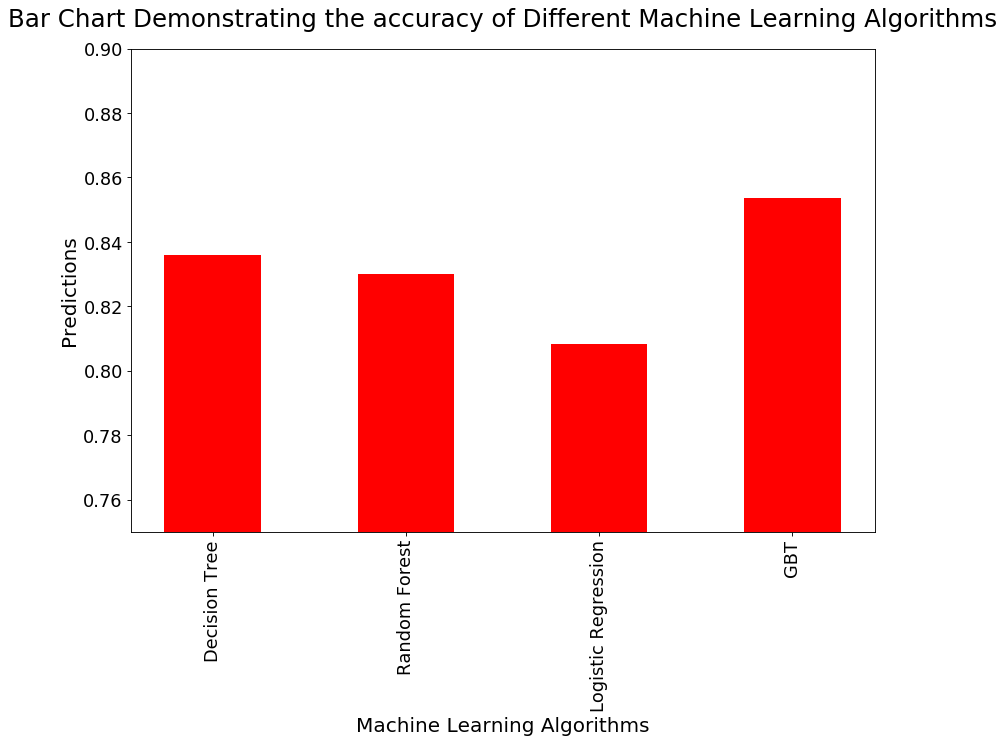

In [22]:
# temp_count_y = crime_df.groupBy(year('Reported Date_').alias('year')).sum().withColumnRenamed('sum(Offence Count)','y_count').orderBy('Year').collect()
# # plot
plt.figure(figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')

bar_width = 0.5
objects = ["Decision Tree", "Random Forest", "Logistic Regression", "GBT"]
y_axis = [accuracyDT, accuracyRF, accuracyLR, accuracyGBT]
y_pos = np.arange(len(objects))

plt.bar(y_pos, y_axis, bar_width, align='center', color='r')
plt.xticks(y_pos, objects, rotation='vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Machine Learning Algorithms', fontsize=18)
plt.ylim([0.75,0.90])
plt.ylabel('Predictions', fontsize=18)
plt.title('Bar Chart Demonstrating the accuracy of Different Machine Learning Algorithms', fontsize=22, pad=20)
plt.show()

## Step 9: Calculate confusion matrix and find precision, recall and F1 score of each algoritm. Explain how the accuracy of the prediction can be improved.

### Confusion matrix and corresponding precision, recall and F1 score of Decision Tree Classifier

In [23]:
DecisionTreeCM = predictionsDT.groupBy('prediction','RainTomorrowIndex').count()
print("Confusion Matrix for Decision Tree Classifier: ")
DecisionTreeCM.show()


TruePosDT = DecisionTreeCM.filter(DecisionTreeCM.prediction ==1).filter(DecisionTreeCM.RainTomorrowIndex ==1).collect()[0][2]
FalseNegDT = DecisionTreeCM.filter(DecisionTreeCM.prediction ==0).filter(DecisionTreeCM.RainTomorrowIndex ==1).collect()[0][2]
FalsePosDT = DecisionTreeCM.filter(DecisionTreeCM.prediction ==1).filter(DecisionTreeCM.RainTomorrowIndex ==0).collect()[0][2]
TrueNegDT = DecisionTreeCM.filter(DecisionTreeCM.prediction ==0).filter(DecisionTreeCM.RainTomorrowIndex ==0).collect()[0][2]

PrecisionDT = TruePosDT / (TruePosDT + FalsePosDT)
RecallDT = TruePosDT / (TruePosDT + FalseNegDT)
F1DT = 2*((PrecisionDT*RecallDT)/(PrecisionDT+RecallDT))


print("\tTrue Positive Count: ", TruePosDT)
print("\tFalse Negitive Count: ", FalseNegDT)
print("\tFalse Positive Count: ", FalsePosDT)
print("\tTrue Negative Count: ", TrueNegDT)
print("")
print("Precesion, Recall and F1 Score of Decision Tree Classifier: ")
print("")
print("\tPrecision :", PrecisionDT)
print("\tRecall :", RecallDT)
print("\tF1 Score :", F1DT)


Confusion Matrix for Decision Tree Classifier: 
+----------+-----------------+-----+
|prediction|RainTomorrowIndex|count|
+----------+-----------------+-----+
|       1.0|              1.0| 4018|
|       0.0|              1.0| 5677|
|       1.0|              0.0| 1340|
|       0.0|              0.0|31747|
+----------+-----------------+-----+

	True Positive Count:  4018
	False Negitive Count:  5677
	False Positive Count:  1340
	True Negative Count:  31747

Precesion, Recall and F1 Score of Decision Tree Classifier: 

	Precision : 0.7499066815976111
	Recall : 0.4144404332129964
	F1 Score : 0.533847073673022


### Confusion matrix and corresponding precision, recall and F1 score of Random Forest Classifier

In [24]:
RandomForestCM = predictionsRF.groupBy('prediction','RainTomorrowIndex').count()
print("Confusion Matrix for Random Forest Classifier: ")
RandomForestCM.show()

TruePosRF = RandomForestCM.filter(RandomForestCM.prediction ==1).filter(RandomForestCM.RainTomorrowIndex ==1).collect()[0][2]
FalseNegRF = RandomForestCM.filter(RandomForestCM.prediction ==0).filter(RandomForestCM.RainTomorrowIndex ==1).collect()[0][2]
FalsePosRF = RandomForestCM.filter(RandomForestCM.prediction ==1).filter(RandomForestCM.RainTomorrowIndex ==0).collect()[0][2]
TrueNegRF = RandomForestCM.filter(RandomForestCM.prediction ==0).filter(RandomForestCM.RainTomorrowIndex ==0).collect()[0][2]

PrecisionRF = TruePosRF / (TruePosRF + FalsePosRF)
RecallRF = TruePosRF / (TruePosRF + FalseNegRF)
F1RF = 2*((PrecisionRF*RecallRF)/(PrecisionRF+RecallRF))

print("\tTrue Positive Count: ", TruePosRF)
print("\tFalse Negitive Count: ", FalseNegRF)
print("\tFalse Positive Count: ", FalsePosRF)
print("\tTrue Negative Count: ", TrueNegRF)
print("")
print("Precesion, Recall and F1 Score of Random Forest Classifier: ")
print("")
print("\tPrecision :", PrecisionRF)
print("\tRecall :", RecallRF)
print("\tF1 Score :", F1RF)

Confusion Matrix for Random Forest Classifier: 
+----------+-----------------+-----+
|prediction|RainTomorrowIndex|count|
+----------+-----------------+-----+
|       1.0|              1.0| 3404|
|       0.0|              1.0| 6291|
|       1.0|              0.0|  978|
|       0.0|              0.0|32109|
+----------+-----------------+-----+

	True Positive Count:  3404
	False Negitive Count:  6291
	False Positive Count:  978
	True Negative Count:  32109

Precesion, Recall and F1 Score of Random Forest Classifier: 

	Precision : 0.776814240073026
	Recall : 0.3511088189788551
	F1 Score : 0.48362577253676203


### Confusion matrix and corresponding precision, recall and F1 score of Logistic Regression Classifier

In [25]:
LogisticRegressionCM = predictionsLR.groupBy('prediction','RainTomorrowIndex').count()

print("Confusion Matrix for Logistic Regression Classifier: ")
LogisticRegressionCM.show()

TruePosLR = LogisticRegressionCM.filter(LogisticRegressionCM.prediction ==1).filter(LogisticRegressionCM.RainTomorrowIndex ==1).collect()[0][2]
FalseNegLR = LogisticRegressionCM.filter(LogisticRegressionCM.prediction ==0).filter(LogisticRegressionCM.RainTomorrowIndex ==1).collect()[0][2]
FalsePosLR = LogisticRegressionCM.filter(LogisticRegressionCM.prediction ==1).filter(LogisticRegressionCM.RainTomorrowIndex ==0).collect()[0][2]
TrueNegLR = LogisticRegressionCM.filter(LogisticRegressionCM.prediction ==0).filter(LogisticRegressionCM.RainTomorrowIndex ==0).collect()[0][2]

PrecisionLR = TruePosLR / (TruePosLR + FalsePosLR)
RecallLR = TruePosLR / (TruePosLR + FalseNegLR)
F1LR = 2*((PrecisionLR*RecallLR)/(PrecisionLR+RecallLR))

print("\tTrue Positive Count: ", TruePosLR)
print("\tFalse Negitive Count: ", FalseNegLR)
print("\tFalse Positive Count: ", FalsePosLR)
print("\tTrue Negative Count: ", TrueNegLR)
print("")
print("Precesion, Recall and F1 Score of Logistic Regression Classifier: ")
print("")
print("\tPrecision :", PrecisionLR)
print("\tRecall :", RecallLR)
print("\tF1 Score :", F1LR)

Confusion Matrix for Logistic Regression Classifier: 
+----------+-----------------+-----+
|prediction|RainTomorrowIndex|count|
+----------+-----------------+-----+
|       1.0|              1.0| 3985|
|       0.0|              1.0| 5710|
|       1.0|              0.0| 2215|
|       0.0|              0.0|30872|
+----------+-----------------+-----+

	True Positive Count:  3985
	False Negitive Count:  5710
	False Positive Count:  2215
	True Negative Count:  30872

Precesion, Recall and F1 Score of Logistic Regression Classifier: 

	Precision : 0.6427419354838709
	Recall : 0.4110366168127901
	F1 Score : 0.5014155394778232


### Confusion matrix and corresponding precision, recall and F1 score of GBT Classifier

In [26]:
GBTCM = predictionsGBT.groupBy('prediction','RainTomorrowIndex').count()

print("Confusion Matrix for GBT Classifier: ")
GBTCM.show()


TruePosGBT = GBTCM.filter(GBTCM.prediction ==1).filter(GBTCM.RainTomorrowIndex ==1).collect()[0][2]
FalseNegGBT = GBTCM.filter(GBTCM.prediction ==0).filter(GBTCM.RainTomorrowIndex ==1).collect()[0][2]
FalsePosGBT = GBTCM.filter(GBTCM.prediction ==1).filter(GBTCM.RainTomorrowIndex ==0).collect()[0][2]
TrueNegGBT = GBTCM.filter(GBTCM.prediction ==0).filter(GBTCM.RainTomorrowIndex ==0).collect()[0][2]

PrecisionGBT = TruePosGBT / (TruePosGBT + FalsePosGBT)
RecallGBT = TruePosGBT / (TruePosGBT + FalseNegGBT)
F1GBT = 2*((PrecisionGBT*RecallGBT)/(PrecisionGBT+RecallGBT))

print("\tTrue Positive Count: ", TruePosGBT)
print("\tFalse Negitive Count: ", FalseNegGBT)
print("\tFalse Positive Count: ", FalsePosGBT)
print("\tTrue Negative Count: ", TrueNegGBT)
print("")
print("Precesion, Recall and F1 Score of GBT Classifier: ")
print("")
print("\tPrecision :", PrecisionGBT)
print("\tRecall :", RecallGBT)
print("\tF1 Score :", F1GBT)

Confusion Matrix for GBT Classifier: 
+----------+-----------------+-----+
|prediction|RainTomorrowIndex|count|
+----------+-----------------+-----+
|       1.0|              1.0| 4357|
|       0.0|              1.0| 5338|
|       1.0|              0.0| 1539|
|       0.0|              0.0|31548|
+----------+-----------------+-----+

	True Positive Count:  4357
	False Negitive Count:  5338
	False Positive Count:  1539
	True Negative Count:  31548

Precesion, Recall and F1 Score of GBT Classifier: 

	Precision : 0.7389755766621439
	Recall : 0.44940691077875194
	F1 Score : 0.5589121929318196


### How to improve the accuracy of the prediction:

Machine Learning Algorithm can be improved with Hyperparameter Tuning, Ensemble Methods and Feature Engineering methods (Seif 2018).
   
    1.  Hyperparameter Tuning: 
        Learned parameters are always changing and updated in the training phase. Setting accurate hyperparameter in the model helps to get more optimal values with given data.
    2.  Ensemble Methods: 
        Machine learning technique that uses multiple predictions of different model is known as ensemble method. With ensemble methods the results are more accurate than any single prediction.
    3.  Feature Engineering: 
        Feature engineering ensures that the model gets only the most optimal features from the input. By applying feature engineering the model uses the data that consistently gives accurate prediction, as a result the model does not have to deal with the extra noise that comes from the other features.

References:


    Seif, G. (2018). 3 ways to improve your Machine Learning results without more data. Retrieved from https://towardsdatascience.com/3-ways-to-improve-your-machine-learning-results-without-more-data-f2f0fe78976e